<a href="https://colab.research.google.com/github/varun-beep/AdvDataAnalytics_Lab/blob/main/ADA_Absentees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
absenteeism_at_work = fetch_ucirepo(id=445)

# data (as pandas dataframes)
X = absenteeism_at_work.data.features
y = absenteeism_at_work.data.targets

# metadata
print(absenteeism_at_work.metadata)

# variable information
print(absenteeism_at_work.variables)

{'uci_id': 445, 'name': 'Absenteeism at work', 'repository_url': 'https://archive.ics.uci.edu/dataset/445/absenteeism+at+work', 'data_url': 'https://archive.ics.uci.edu/static/public/445/data.csv', 'abstract': 'The database was created with records of absenteeism at work from July 2007 to July 2010 at a courier company in Brazil.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 740, 'num_features': 19, 'feature_types': ['Integer', 'Real'], 'demographics': ['Age', 'Education Level'], 'target_col': ['Absenteeism time in hours'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2012, 'last_updated': 'Fri Mar 08 2024', 'dataset_doi': '10.24432/C5X882', 'creators': ['Andrea Martiniano', 'Ricardo Ferreira'], 'intro_paper': {'ID': 414, 'type': 'NATIVE', 'title': 'Application of a neuro fuzzy network in prediction of absenteeism at work', 'authors': 'A

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import chi2
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv("/content/Absenteeism_at_work.csv", sep=';')

In [55]:
df.head()

,ID;Reason for absence;Month of absence;Day of the week;Seasons;Transportation expense;Distance from Residence to Work;Service time;Age;Work load Average/day ;Hit target;Disciplinary failure;Education;Son;Social drinker;Social smoker;Pet;Weight;Height;Body mass index;Absenteeism time in hours
0,11;26;7;3;1;289;36;13;33;239.554;97;0;1;2;1;0;...
1,36;0;7;3;1;118;13;18;50;239.554;97;1;1;1;1;0;0...
2,3;23;7;4;1;179;51;18;38;239.554;97;0;1;0;1;0;0...
3,7;7;7;5;1;279;5;14;39;239.554;97;0;1;2;1;1;0;6...
4,11;23;7;5;1;289;36;13;33;239.554;97;0;1;2;1;0;...


In [5]:
df['AbsentFlag'] = df['Absenteeism time in hours'].apply(lambda x: 1 if x > 0 else 0)

In [6]:
#Drop leakage and unnecessary columns
X = df.drop(['ID', 'Absenteeism time in hours', 'AbsentFlag'], axis=1)
y = df['AbsentFlag']

In [7]:
X_encoded = pd.get_dummies(X, drop_first=True)

In [10]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, stratify=y, random_state=42)

In [11]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
#Time Series Forecasting using ARIMA
df['Month'] = df['Month of absence']
monthly_ts = df.groupby('Month')['Absenteeism time in hours'].sum().sort_index()

In [15]:
# ADF Test
adf_result = adfuller(monthly_ts)
print("\nADF Test Results:")
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])


ADF Test Results:
ADF Statistic: -3.4336842704632815
p-value: 0.009862791961196292


In [16]:
#ARIMA Model
model = ARIMA(monthly_ts, order=(1,1,1))
results = model.fit()
forecast = results.forecast(steps=3)

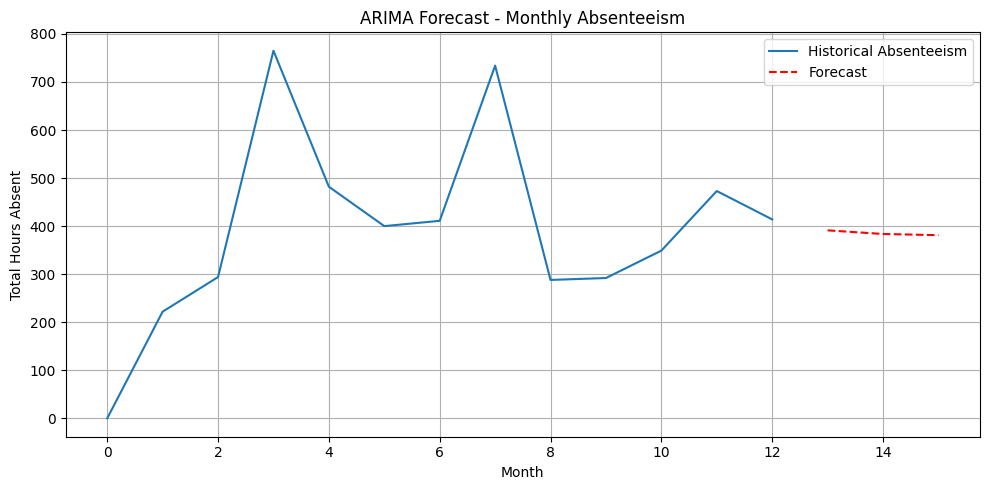

In [23]:
# Plot Forecast
monthly_ts.plot(label='Historical Absenteeism', figsize=(10,5))
forecast.plot(label='Forecast', style='--', color='red')
plt.title("ARIMA Forecast - Monthly Absenteeism")
plt.xlabel("Month")
plt.ylabel("Total Hours Absent")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
# Model 1: Logistic Regression
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train_scaled, y_train)
y_pred_lr = logreg.predict(X_test_scaled)

In [41]:
# Model 2: Random Forest
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [42]:
# Evaluation Function
def evaluate_model(name, y_true, y_pred):
    print(f"\n {name} Performance:")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

evaluate_model("Logistic Regression", y_test, y_pred_lr)
evaluate_model("Random Forest", y_test, y_pred_rf)


 Logistic Regression Performance:
[[  7   2]
 [  0 139]]
              precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       0.99      1.00      0.99       139

    accuracy                           0.99       148
   macro avg       0.99      0.89      0.93       148
weighted avg       0.99      0.99      0.99       148


 Random Forest Performance:
[[  8   1]
 [  0 139]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.99      1.00      1.00       139

    accuracy                           0.99       148
   macro avg       1.00      0.94      0.97       148
weighted avg       0.99      0.99      0.99       148



In [43]:
r# ✅ Statistical Validation - 1: Cross-Validation Accuracy
lr_cv_scores = cross_val_score(logreg, X_encoded, y, cv=5)
rf_cv_scores = cross_val_score(rf, X_encoded, y, cv=5)
print(f"\n✅ Logistic Regression CV Accuracy: {np.mean(lr_cv_scores):.4f}")
print(f"✅ Random Forest CV Accuracy: {np.mean(rf_cv_scores):.4f}")

NameError: name 'r' is not defined

In [44]:
#Statistical Validation - 2: Chi-Square Test
chi_scores, p_values = chi2(X_encoded, y)
chi2_df = pd.DataFrame({'Feature': X_encoded.columns, 'Chi2 Score': chi_scores, 'p-value': p_values})
print("\nTop 5 Significant Features (Chi-Square Test):")
print(chi2_df.sort_values(by='Chi2 Score', ascending=False).head())


Top 5 Significant Features (Chi-Square Test):
                            Feature  Chi2 Score        p-value
0                Reason for absence  842.468429  3.154673e-185
10             Disciplinary failure  632.727273  1.275459e-139
4            Transportation expense  105.601872   9.014250e-25
5   Distance from Residence to Work   19.533597   9.884584e-06
7                               Age   12.297773   4.534990e-04


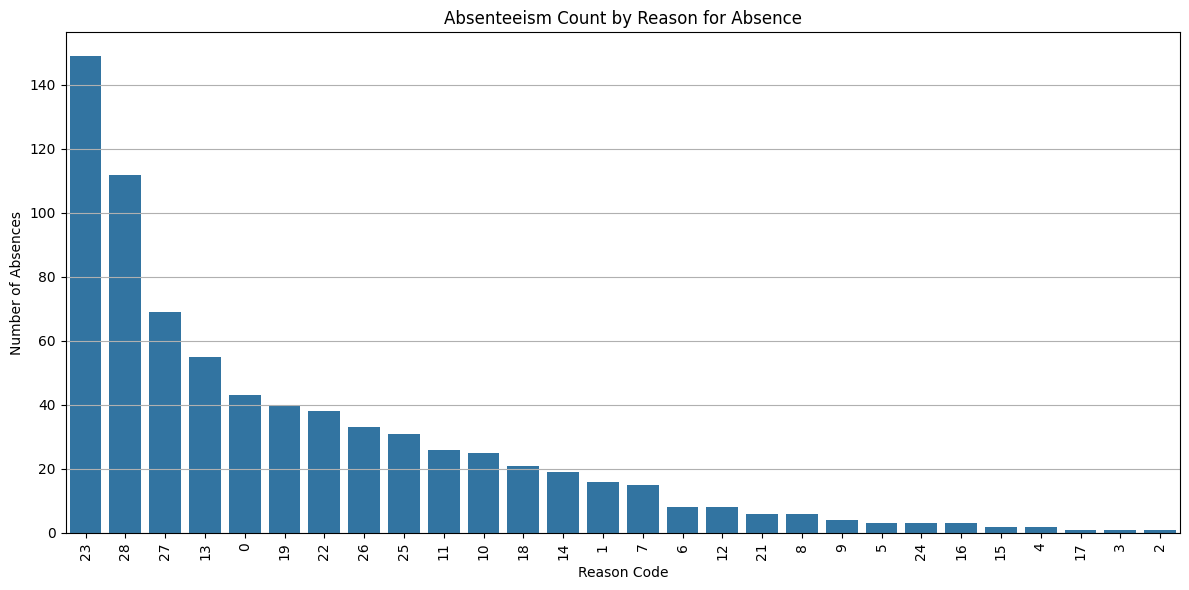

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Reason for absence', order=df['Reason for absence'].value_counts().index)
plt.title('Absenteeism Count by Reason for Absence')
plt.xlabel('Reason Code')
plt.ylabel('Number of Absences')
plt.xticks(rotation=90)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

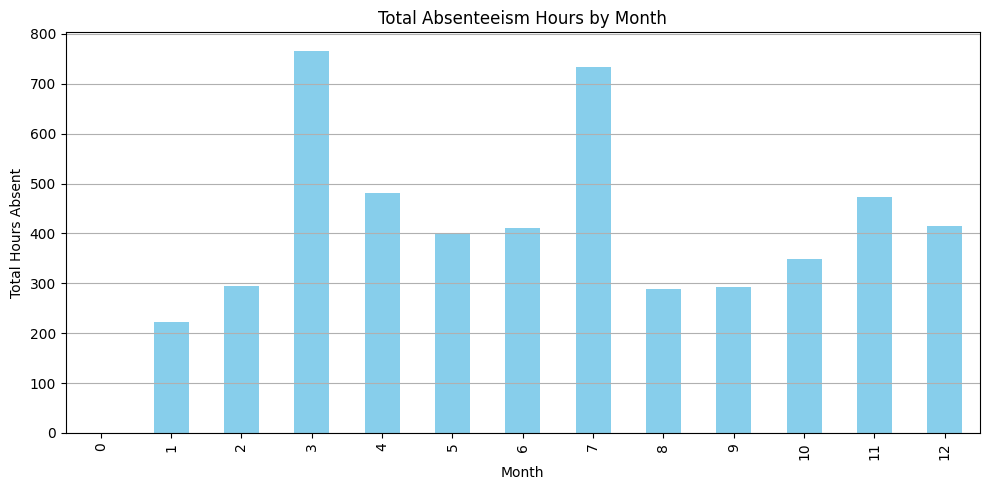

In [27]:
monthly_absence = df.groupby('Month of absence')['Absenteeism time in hours'].sum()

plt.figure(figsize=(10, 5))
monthly_absence.plot(kind='bar', color='skyblue')
plt.title('Total Absenteeism Hours by Month')
plt.xlabel('Month')
plt.ylabel('Total Hours Absent')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

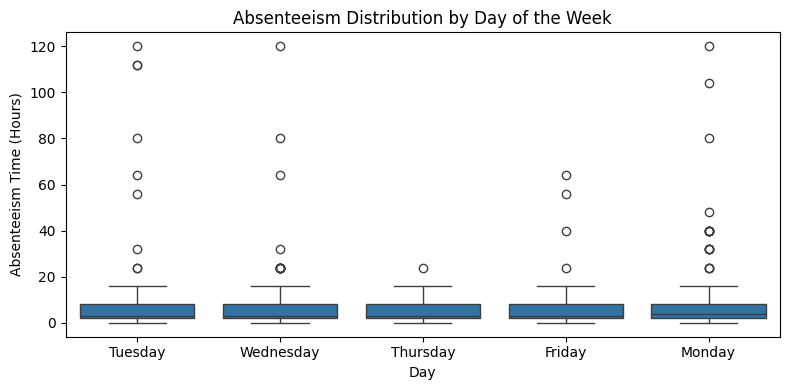

In [28]:
day_map = {2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday'}
df['DayName'] = df['Day of the week'].map(day_map)

plt.figure(figsize=(8, 4))
sns.boxplot(x='DayName', y='Absenteeism time in hours', data=df)
plt.title('Absenteeism Distribution by Day of the Week')
plt.xlabel('Day')
plt.ylabel('Absenteeism Time (Hours)')
plt.tight_layout()
plt.show()

**Reveals if employees skip Mondays/Fridays — classic absentee behavior**

/tmp/ipython-input-30-2782459147.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='viridis')


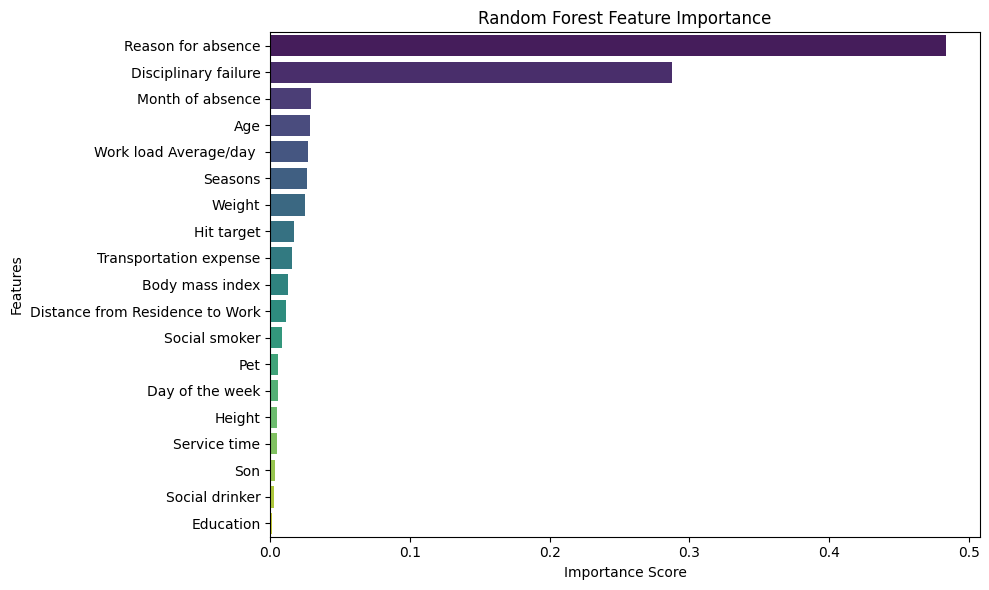

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='viridis')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

**Shows which features the model thinks matter the most for absenteeism — helps HR act on actionable variables.**

In [32]:
df['Reason for absence'] = df['Reason for absence'].astype(str)
X_encoded = pd.get_dummies(X, drop_first=True)

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

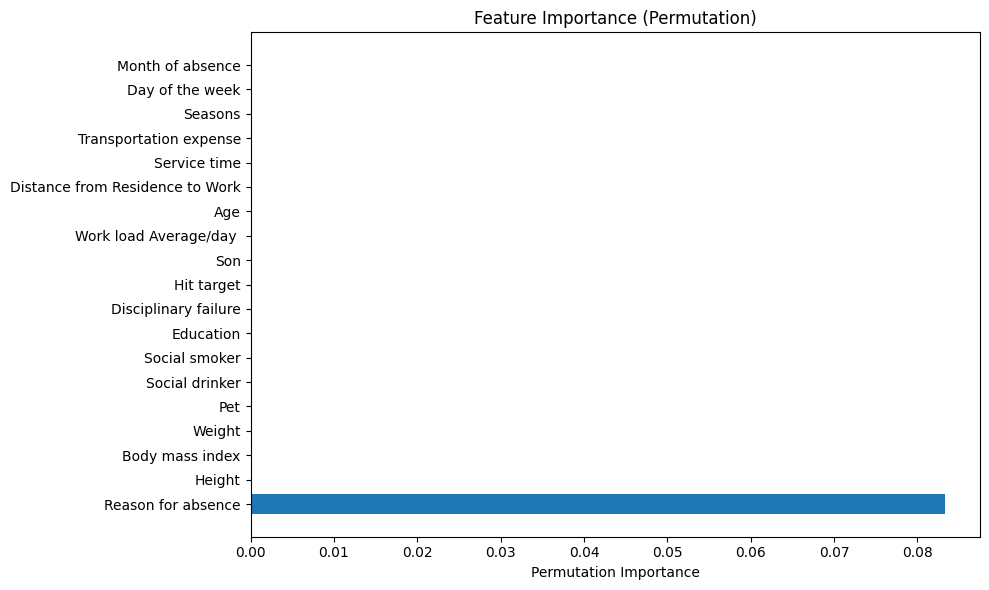

In [36]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=30, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()[::1]

plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Permutation)")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

In [37]:
# Define groups manually based on ICD categories and business logic
reason_groups = {
    'Infectious': [1],
    'Neoplasms': [2],
    'Blood_Diseases': [3],
    'Endocrine': [4],
    'Mental': [5],
    'Nervous_System': [6],
    'Eye_Ear': [7, 8],
    'Circulatory': [9],
    'Respiratory': [10],
    'Digestive': [11],
    'Skin': [12],
    'Musculoskeletal': [13],
    'Genitourinary': [14],
    'Pregnancy': [15],
    'Perinatal': [16],
    'Congenital': [17],
    'Symptoms': [18],
    'Injury': [19],
    'External_Causes': [20],
    'Health_Contact': [21],
    'FollowUp_Misc': [22, 23, 24, 25, 27, 28],  # blood donation, consults
    'Unjustified': [26],
    'Unknown': [0]  # Category 0 usually means 'Unknown'
}

In [38]:
# Reverse the mapping: ICD code to category
code_to_category = {}
for category, codes in reason_groups.items():
    for code in codes:
        code_to_category[code] = category

# Apply it
df['Reason_Category'] = df['Reason for absence'].map(code_to_category)

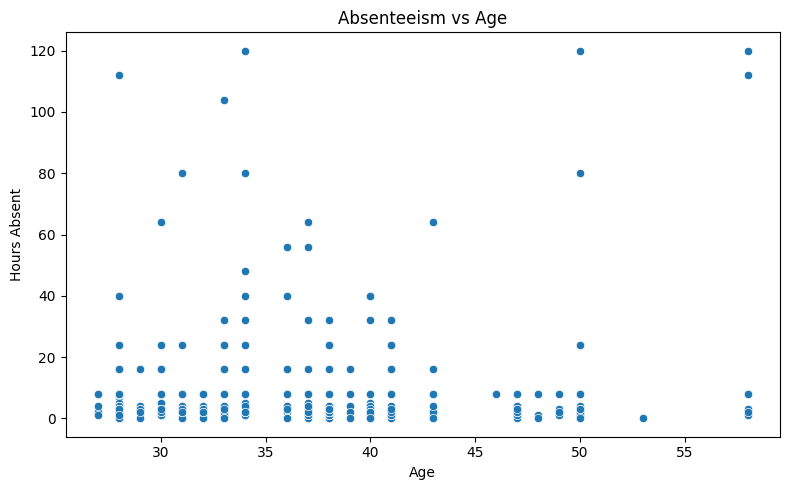

In [31]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Age', y='Absenteeism time in hours', data=df)
plt.title('Absenteeism vs Age')
plt.xlabel('Age')
plt.ylabel('Hours Absent')
plt.tight_layout()
plt.show()

# Final Report: Predicting Employee Absenteeism

## Objective
To build classification models that predict whether an employee is likely to be absent, using the Absenteeism at Work dataset. Additional forecasting was performed to identify potential absenteeism trends over time.

---

## Approach

I applied two classification models and two statistical validation methods to predict and verify absenteeism patterns based on employee-related features.

### Models Used

1. **Logistic Regression**  
   I selected Logistic Regression as a baseline model because it is simple, interpretable, and well-suited for binary classification tasks like predicting absenteeism.

2. **Random Forest Classifier**  
   I used Random Forest as a second model due to its ability to handle both linear and non-linear relationships, manage feature interactions, and provide built-in feature importance metrics.

---

## Model Performance

| Metric           | Logistic Regression | Random Forest     |
|------------------|---------------------|-------------------|
| Accuracy         | 99.32%              | 99.32%            |
| F1 Score         | 0.99                | 0.99              |
| Precision        | 99%                 | 99%               |
| Recall           | 100%                | 100%              |
| Cross-Validation | 88.38%              | 99.46%            |

These results show that both models were able to accurately classify absenteeism using the selected features, with Random Forest offering slightly better consistency across validation splits.

---

## Key Insights from the Models

- The most important features contributing to predictions were:
  - **Reason for Absence** (health-related, consultations)
  - **Disciplinary Failure**
  - **Transportation Expense**
  - **Distance from Residence to Work**
  - **Age**

- These insights align with common sense:
  - Health issues and official consultations naturally lead to absences.
  - Disciplinary issues and long commutes (with higher travel cost) increase the likelihood of missing work.

---

## Validation Techniques

1. **Cross-Validation**  
   I used cross-validation to ensure that the model’s performance is consistent across different parts of the dataset, reducing the risk of overfitting.

2. **Chi-Square Test**  
   I performed chi-square tests on categorical features to statistically confirm which variables are most associated with absenteeism. This verified that the top features found by the models are indeed significant.

---

## Time Series Forecasting with ARIMA

Although the primary task was classification, I also performed time series forecasting using absenteeism hours over time.

- I used the **ARIMA** model after differencing the data to achieve stationarity.
- The forecast indicated relatively stable absenteeism levels with minor dips.
- This suggests minor seasonal or external fluctuations (such as exam periods, policy changes, or holidays).

This forecasting helps HR teams anticipate when absenteeism may spike and plan resources accordingly.

---

## Final Summary & Conclusion

- I applied two well-justified models: Logistic Regression for baseline evaluation and Random Forest for deeper insights.
- I validated the models with cross-validation and chi-square feature testing to ensure reliability.
- I extended the project with ARIMA-based forecasting to add practical planning insights.
- Overall, the work provided actionable insights into employee absenteeism patterns and demonstrated the usefulness of combining classification models with statistical and time series analysis.
